In [15]:
from chemtbd.io import Agilent
from scipy.stats import linregress
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
agi = Agilent.from_root('data')

__matclibarea_one__ matches lib dataframe to fid or tic dataframes

- key: string, typically the file name
- libdf: dataframe, dataframe containing chemical identification information i.e. library/id, rt, etc
- areaddf: dataframe, dataframe containing either tic or fid areas and retetion times (rt)
- areatype: string, `fid` or `tic`

example:
```
key = 'FA13.D'
libdf = agi[key].results.lib
ticdf  = agi[key].results.tic
fiddf = agi[key].results.fid
matchlib2area_one('FA14.D',libdf,ticdf,'tic')
```

__matchlib2area_all__ matches lib dataframe to fid or tic dataframes for all data sets in a folder containing .D files generated from Agilent

example:
```
matched_df = matchlib2area_all(agi,'tic')
```

In [3]:
def matchlib2area_one(key,libdf, areadf,areatype):
    returndf = libdf.copy()
    
    if areatype == 'tic':
        colname = 'tic_area'
    elif areatype == 'fid':
        colname = 'fid_area'
    else:
        print('incorrect area type')

    returndf[colname] = np.nan
    #find shortest
    if len(libdf) <= len(areadf):
        short = libdf
        long = areadf
    else:
        short = areadf
        long = libdf
        
    #loop and match
    match_list = []
    for index,row in short.iterrows():
        sqrError = (short['rt'].ix[index]-long['rt'].ix[index:len(long)])**2    
        area_row = sqrError.idxmin(axis=1)
        match_list.append(areadf['area'].ix[area_row])
    if areatype == 'tic':
        returndf['tic_area'] = match_list
    elif areatype == 'fid':
        returndf['fid_area'] = match_list
    
    return returndf

def matchlib2area_all(data_dic,areatype='tic'):
    libdf = data_dic.results('lib').groupby('key')
    areadf  = data_dic.results(areatype).groupby('key')

    #return_dic = {}
    return_df = pd.DataFrame()
    for name, group in libdf:
        try:
            return_df = return_df.append(matchlib2area_one(name,group,areadf.get_group(name),areatype))
            # return_dic[name] = matchlib2area_one(name,group,areadf.get_group(name),areatype)
        except:
            print(name+' did not match successfully')
    return return_df.reset_index()

matched_df = matchlib2area_all(agi,'tic')
matched_df.head()

FA14_2.D did not match successfully


,index,header=,pk,rt,pct_area,library_id,ref,cas,qual,key,tic_area
0,0,1=,1.0,5.7877,2.0335,Methyl octanoate,17.0,000000-00-0,96.0,FA03.D,1489466.0
1,1,2=,2.0,7.3441,3.4015,Methyl decanoate,1.0,000000-00-0,98.0,FA03.D,2491449.0
2,2,3=,3.0,8.0364,1.7448,Methyl undecanoate,2.0,000000-00-0,98.0,FA03.D,1277982.0
3,3,4=,4.0,8.6715,3.9674,Methyl dodecanoate,3.0,000000-00-0,98.0,FA03.D,2905961.0
4,4,5=,5.0,9.2781,1.9607,Methyl tridecanoate,4.0,000000-00-0,99.0,FA03.D,1436154.0


This creates a df containing the concentrations, I assumed the starting concentration of the stock was 1M, to get from hanna. The general data input represented by __calc_conc_df__ will always be this format; however, we will need to have a different ways for the user to input this information

In [39]:
cal_files = ['FA03.D','FA04.D','FA05.D']
cal_dilutions = {'FA03.D': 0.25,'FA04.D':0.50,'FA05.D':1.0}
standards = pd.DataFrame({'library_id':agi['FA05.D'].results['lib']['library_id'],'Conc_0':1})

for key,val in cal_dilutions.items():
    standards[key] = standards['Conc_0']*val
standards.drop('Conc_0',1,inplace=True)
standards.head()

,library_id,FA03.D,FA04.D,FA05.D
0,Methyl hexanoate,0.25,0.5,1.0
1,Methyl octanoate,0.25,0.5,1.0
2,Methyl decanoate,0.25,0.5,1.0
3,Methyl undecanoate,0.25,0.5,1.0
4,Methyl dodecanoate,0.25,0.5,1.0


Calculate a linear fit to calibration data for each species

In [40]:
def match_cal_conc(matched_df, standards):
    '''
    this  function takes a dataframe which contains species matched to an area (matched_df) 
    and a calibration concentration dataframe and matches these two based on library_id
    '''
    standards_melted = pd.melt(standards, id_vars=['library_id'],value_vars=cal_files)
    standards_melted.columns = ['library_id','key','cal_conc']
    
    return_df = pd.merge(matched_df,standards_melted,how='left',on=['library_id','key'])
    return return_df.dropna(subset=['cal_conc'])

matched_cal_conc = match_cal_conc(matched_df, standards)

def cal_curves_tic(matched_cal_conc):
    '''
    this function takes a matched calibration concentration dataframe (matched_cal_conc)
    and does a linear regression and returns a dataframe of the library_ids with 
    linregress stats and the min/max areas which is the range for which the calibration
    curve can (should only) be used.
    
    this is only for tic data, fid data calculation will be different
    '''
    b = (matched_cal_conc.groupby('library_id')
                         .apply(lambda a: linregress(a.tic_area,a.cal_conc))
                         .apply(pd.Series)
                         .reset_index())
    b.columns = ['library_id','slope','intercept','rvalue','pvalue','stderr']

    d = pd.DataFrame({'max':matched_cal_conc.groupby('library_id')['tic_area'].max(),
                    'min':matched_cal_conc.groupby('library_id')['tic_area'].min()}).reset_index()
    return pd.merge(b,d,on='library_id')
#pd.merge(b,d,on='library_id')

calced_curves = cal_curves_tic(matched_cal_conc)
calced_curves.head()

D:\Applications\Anaconda\envs\chemtool\lib\site-packages\scipy\stats\_stats_mstats_common.py:106: RuntimeWarning: invalid value encountered in double_scalars
  slope = r_num / ssxm
D:\Applications\Anaconda\envs\chemtool\lib\site-packages\scipy\stats\_stats_mstats_common.py:116: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
D:\Applications\Anaconda\envs\chemtool\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
D:\Applications\Anaconda\envs\chemtool\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
D:\Applications\Anaconda\envs\chemtool\lib\site-packages\scipy\stats\_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
D:\Applications\Anaconda\envs\chemtool\lib\site-

,library_id,slope,intercept,rvalue,pvalue,stderr,max,min
0,"All cis-4,7,10,13,16,19-docosahexaenoate methy...",1.367304e-07,0.103774,0.999932,7.420556e-03,1.593827e-09,6566581.0,1094384.0
1,Methyl arachidate,7.146232e-08,-0.063537,0.999076,2.736712e-02,3.073928e-09,14785000.0,4222622.0
2,Methyl arachidonate,1.344684e-07,0.067813,0.999319,7.894786e-10,2.027146e-09,7056294.0,1390417.0
3,"Methyl cis-11,14,17-eicosatrienoate",1.306034e-07,0.102132,1.000000,0.000000e+00,0.000000e+00,6874772.0,3046387.0
4,Methyl cis-11-eicosenoate,6.336257e-08,0.008515,1.000000,1.097315e-04,1.092154e-11,15647413.0,3810380.0


In [168]:
def calc_conc_tic(cal_curves, matched_df):
    '''
    this  function takes a dataframe which contains species matched to an area (matchlib2area_all) 
    and a calibration curve dataframe (cal_curves_tic)
    '''
    def conc_cal(x):
        conc = (x['tic_area']*x['slope']+x['intercept'] if x['tic_area']*x['slope']+x['intercept']>0 else NaN)
        return conc
    
    # calculate concentration of species
    return_df = pd.merge(matched_df,cal_curves,on='library_id',how='outer')
    return_df['conc'] = return_df.apply(conc_cal,axis=1)
    return_df.drop(['rvalue','pvalue','stderr'],1,inplace=True)

    #calculate concentration percentage 
    totals_c = pd.DataFrame({'totals_c':(return_df.groupby('key')['conc']
                                            .apply(np.sum,axis=0))}).reset_index()                     
    return_df = return_df.merge(totals_c, on=['key'])
    return_df['conc%']=return_df['conc']/return_df['totals_c']
    return_df.drop(['totals_c'],1,inplace=True)
    
    #calculate area percentage
    totals_a = pd.DataFrame({'totals_a':(return_df.groupby('key')['tic_area']
                                            .apply(np.sum,axis=0))}).reset_index()                     
    return_df = return_df.merge(totals_a, on=['key'])
    return_df['tic_area%']=return_df['tic_area']/return_df['totals_a']
    return_df.drop(['totals_a'],1,inplace=True)
    
    return return_df

calced_conc_tic = calc_conc_tic(calced_curves, matched_df)
calced_conc_tic.head()

NameError: ("name 'NaN' is not defined", 'occurred at index 59')

library_id,Methyl linolelaidate,Methyl myristate,Methyl palmitate,Methyl palmitoleate,Methyl stearate,cis-10-Pentadecenoic acid methyl ester,cis-9-Oleic methyl ester
key,,,,,,,
FA08.D,0.0,NaN,NaN,NaN,NaN,1.0,NaN
FA09.D,0.0,NaN,NaN,NaN,NaN,1.0,NaN
FA11.D,NaN,NaN,0.517033,0.482967,0.0,NaN,0.0
FA12.D,NaN,NaN,0.605204,0.394796,0.0,NaN,0.0
FA13.D,NaN,0.086935,0.429016,0.484048,0.0,NaN,0.0
FA14.D,NaN,NaN,0.610657,0.389343,0.0,NaN,0.0


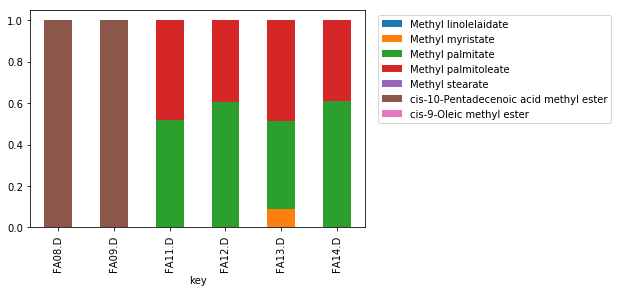

In [165]:
def plot_tic(calced_conc_tic,standards = pd.DataFrame()):
    standard_keys = list(standards.keys()[1:])
    
    #Standards Plot
    
    
    #Concetration Stacked Plot
    unknowns_df = calced_conc_tic[-calced_conc_tic['key'].isin(standard_keys)]
    unknowns_pvt = pd.pivot_table(unknowns_df,
                               index='key',
                               columns='library_id',
                               values='conc%')
    unknowns_plt = unknowns_pvt.plot(legend=True,
                    kind='bar',
                    stacked=True,
                    figsize = (6,4))
    unknowns_plt.legend(bbox_to_anchor=(0.75,0,1, 1),loc='upper right')
    
    #concentration trend plot
    
    return unknowns_pvt

plot_tic(calced_conc_tic,standards)


Fuctions which still need to be built

In [8]:


def make_plot_percentarea():
    pass

def make_plot_concarea():
    pass

def make_plot_massarea():
    pass

def calc_mass():
    pass